In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
%matplotlib inline

In [2]:
!pwd

/content


In [3]:
from googleapiclient.discovery import build
import io, os
from googleapiclient.http import MediaIoBaseDownload
from google.colab import auth


auth.authenticate_user()

drive_service = build('drive', 'v3')
results = drive_service.files().list(
        q="name = 'kaggle.json'", fields="files(id)").execute()
kaggle_api_key = results.get('files', [])

filename = "/root/.kaggle/kaggle.json"
os.makedirs(os.path.dirname(filename), exist_ok=True)

request = drive_service.files().get_media(fileId=kaggle_api_key[0]['id'])
fh = io.FileIO(filename, 'wb')
downloader = MediaIoBaseDownload(fh, request)
done = False
while done is False:
    status, done = downloader.next_chunk()
    print("Download %d%%." % int(status.progress() * 100))
os.chmod(filename, 600)

Download 100%.


In [4]:
!kaggle competitions download -c web-traffic-time-series-forecasting

 84% 57.0M/68.2M [00:00<00:00, 76.0MB/s]
100% 68.2M/68.2M [00:00<00:00, 106MB/s] 
 86% 57.0M/66.0M [00:00<00:00, 32.1MB/s]
100% 66.0M/66.0M [00:00<00:00, 78.3MB/s]
 91% 137M/150M [00:00<00:00, 132MB/s]
100% 150M/150M [00:00<00:00, 163MB/s]
 88% 89.0M/101M [00:01<00:00, 57.9MB/s]
100% 101M/101M [00:01<00:00, 93.7MB/s] 
 84% 81.0M/96.0M [00:00<00:00, 80.4MB/s]
100% 96.0M/96.0M [00:01<00:00, 98.9MB/s]
 89% 91.0M/102M [00:00<00:00, 94.9MB/s]
100% 102M/102M [00:00<00:00, 120MB/s]  


In [5]:
!unzip train_1.csv

Archive:  train_1.csv.zip
  inflating: train_1.csv             


## Overview of Data

First, let's take a look at our traning set.

In [0]:
train = pd.read_csv(r"train_1.csv")

In [7]:
train.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,2015-07-10,2015-07-11,2015-07-12,2015-07-13,2015-07-14,2015-07-15,2015-07-16,2015-07-17,2015-07-18,2015-07-19,2015-07-20,2015-07-21,2015-07-22,2015-07-23,2015-07-24,2015-07-25,2015-07-26,2015-07-27,2015-07-28,2015-07-29,2015-07-30,2015-07-31,2015-08-01,2015-08-02,2015-08-03,2015-08-04,2015-08-05,2015-08-06,2015-08-07,2015-08-08,...,2016-11-22,2016-11-23,2016-11-24,2016-11-25,2016-11-26,2016-11-27,2016-11-28,2016-11-29,2016-11-30,2016-12-01,2016-12-02,2016-12-03,2016-12-04,2016-12-05,2016-12-06,2016-12-07,2016-12-08,2016-12-09,2016-12-10,2016-12-11,2016-12-12,2016-12-13,2016-12-14,2016-12-15,2016-12-16,2016-12-17,2016-12-18,2016-12-19,2016-12-20,2016-12-21,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,24.0,19.0,10.0,14.0,15.0,8.0,16.0,8.0,8.0,16.0,7.0,11.0,10.0,20.0,18.0,15.0,14.0,49.0,10.0,16.0,18.0,8.0,5.0,9.0,7.0,13.0,9.0,7.0,4.0,11.0,...,24.0,14.0,11.0,204.0,14.0,45.0,33.0,28.0,18.0,14.0,47.0,15.0,14.0,18.0,20.0,14.0,16.0,14.0,20.0,60.0,22.0,15.0,17.0,19.0,18.0,21.0,21.0,47.0,65.0,17.0,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,4.0,41.0,65.0,57.0,38.0,20.0,62.0,44.0,15.0,10.0,47.0,24.0,17.0,22.0,9.0,39.0,13.0,11.0,12.0,21.0,19.0,9.0,15.0,33.0,8.0,8.0,7.0,13.0,2.0,23.0,...,14.0,15.0,15.0,11.0,20.0,13.0,19.0,621.0,57.0,17.0,23.0,19.0,21.0,47.0,28.0,22.0,22.0,65.0,27.0,17.0,17.0,13.0,9.0,18.0,22.0,17.0,15.0,22.0,23.0,19.0,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,4.0,1.0,1.0,1.0,6.0,8.0,6.0,4.0,5.0,1.0,2.0,3.0,8.0,8.0,6.0,6.0,2.0,2.0,3.0,2.0,4.0,3.0,3.0,5.0,3.0,5.0,4.0,2.0,5.0,1.0,...,9.0,3.0,5.0,4.0,0.0,1.0,4.0,5.0,8.0,8.0,1.0,1.0,2.0,5.0,3.0,3.0,3.0,7.0,3.0,9.0,8.0,3.0,210.0,5.0,4.0,6.0,2.0,2.0,4.0,3.0,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,16.0,16.0,11.0,23.0,145.0,14.0,17.0,85.0,4.0,30.0,22.0,9.0,10.0,11.0,7.0,7.0,11.0,9.0,11.0,44.0,8.0,14.0,19.0,10.0,17.0,17.0,10.0,7.0,10.0,1.0,...,7.0,10.0,7.0,10.0,14.0,17.0,11.0,9.0,11.0,5.0,10.0,8.0,17.0,13.0,23.0,40.0,16.0,17.0,41.0,17.0,8.0,9.0,18.0,12.0,12.0,18.0,13.0,18.0,23.0,10.0,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,14.0,13.0,15.0,14.0,16.0,9.0,178.0,64.0,12.0,10.0,11.0,6.0,8.0,7.0,9.0,8.0,5.0,11.0,8.0,4.0,15.0,5.0,8.0,8.0,6.0,7.0,15.0,4.0,11.0,7.0,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


So, our data consist of...
* Page:  The name of each wikipedia page.
* yyyy-mm-dd :  The days views were recorded. (2015-07-01 - 2016-12-31,  550 days in total) 


## Missing Data

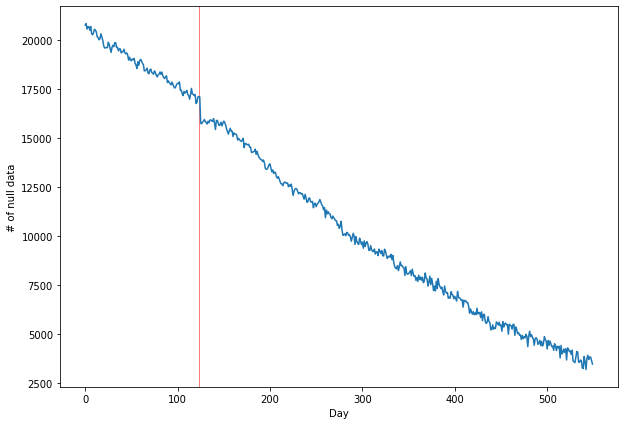

In [9]:
# Missing data per day

days = [r for r in range(train.shape[1] - 1)]
fig, ax = plt.subplots(figsize = (10,7))
plt.xlabel('Day')
plt.ylabel('# of null data')
ax.axvline(x=123, c = 'red',  lw = 0.5)
plt.plot(days, train.iloc[:,1:].isnull().sum())

In [10]:
train.columns[123]

'2015-10-31'

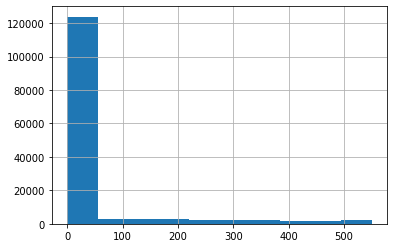

In [11]:
# Histogram of pages with their number of data missing. 

train.isnull().sum(axis = 1).hist()

* OK, so we have quite lots of null data in the beggining, but decreases as the time goes.
* Perhaps, some pages were newly created?
* However, many pages have no missing data as seen from the second diagram.

I will fill them with 0 as it makes it easier to continue.

In [0]:
train = train.fillna(0)

## Feature Engineering
First I will take a look at each page name. The general format is 

```
SPECIFIC NAME _ LANGUAGE.wikipedia.org _ ACESS TYPE _ ACCESS ORIGIN
``` 

So we can split them with the underscore and dots.

In [13]:
train.Page

0                   2NE1_zh.wikipedia.org_all-access_spider
1                    2PM_zh.wikipedia.org_all-access_spider
2                     3C_zh.wikipedia.org_all-access_spider
3                4minute_zh.wikipedia.org_all-access_spider
4         52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...
                                ...                        
145058    Underworld_(serie_de_películas)_es.wikipedia.o...
145059    Resident_Evil:_Capítulo_Final_es.wikipedia.org...
145060    Enamorándome_de_Ramón_es.wikipedia.org_all-acc...
145061    Hasta_el_último_hombre_es.wikipedia.org_all-ac...
145062    Francisco_el_matemático_(serie_de_televisión_d...
Name: Page, Length: 145063, dtype: object

In [0]:
import re
def split_page(page):
  w = re.split('_|\.', page)
  return ' '.join(w[:-5]), w[-5], w[-2], w[-1]

li = list(train.Page.apply(split_page))
df = pd.DataFrame(li)
df.columns = ['Title', 'Language', 'Access_type','Access_origin']
df = pd.concat([train, df], axis = 1)
del df['Page']

In [15]:
df.iloc[:, -4:]

,Title,Language,Access_type,Access_origin
0,2NE1,zh,all-access,spider
1,2PM,zh,all-access,spider
2,3C,zh,all-access,spider
3,4minute,zh,all-access,spider
4,52 Hz I Love You,zh,all-access,spider
...,...,...,...,...
145058,Underworld (serie de películas),es,all-access,spider
145059,Resident Evil: Capítulo Final,es,all-access,spider
145060,Enamorándome de Ramón,es,all-access,spider
145061,Hasta el último hombre,es,all-access,spider


Okay, so now the Page name is split into 
* Title (title of the page)
* Language (languaeg written with)
* Access_type (the type of access)
*Acceess_origin (the type of access) 


In [16]:
df[df.Language == 'de'].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
46371,10 Cloverfield Lane,de,all-access,spider
46372,11 November,de,all-access,spider
46373,12 Monkeys,de,all-access,spider
46374,187 Strassenbande,de,all-access,spider
46375,1944 (Lied),de,all-access,spider
...,...,...,...,...
141521,Anschlag auf den Berliner Weihnachtsmarkt an d...,de,all-access,all-agents
141522,Hacksaw Ridge – Die Entscheidung,de,all-access,all-agents
141523,Flugunfall der KLM Fokker F XXII „Kwikstaart“,de,all-access,all-agents
141524,Winnetou – Der Mythos lebt,de,all-access,all-agents


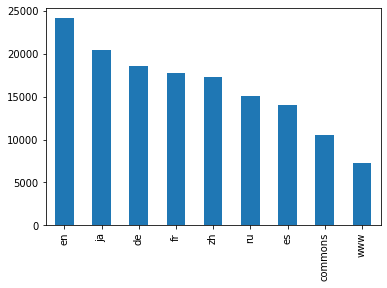

In [17]:
df.Language.value_counts().plot(kind = 'bar')

* There are actually pages with unspecific languages: commons and www.
* Others are English, Japanese, German, French, Chinese, Russian, Spanish

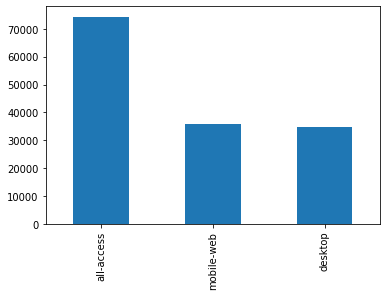

In [18]:
df.Access_type.value_counts().plot(kind = 'bar')

* There are three types of access: all-access, mobike, and desktop

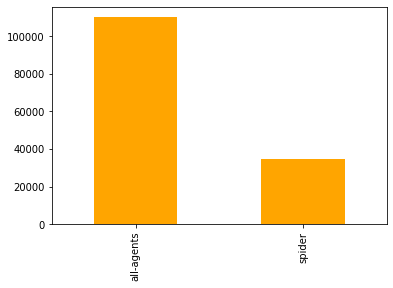

In [19]:
df.Access_origin.value_counts().plot(kind = 'bar', color = 'orange')

* The acess origins are either all-agents or spider. 

Okay, so now we have global categorical features. Let's take a look at the time series data.

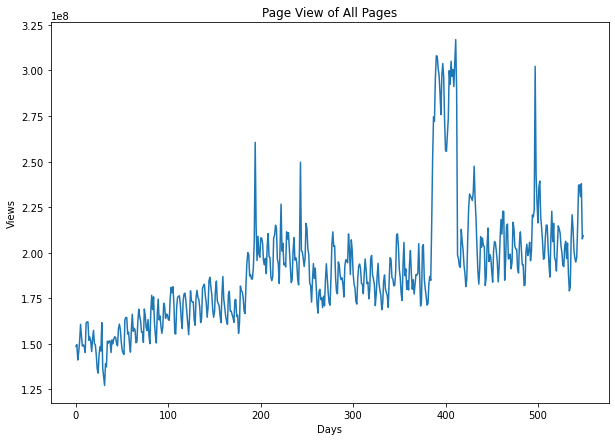

In [20]:
sum_all = df.iloc[:,:-4].sum(axis = 0)

days = list(r for r in range(sum_all.shape[0]))

fig = plt.figure(figsize = (10, 7))
plt.xlabel('Days')
plt.ylabel('Views')
plt.title('Page View of All Pages')
plt.plot(days, sum_all)


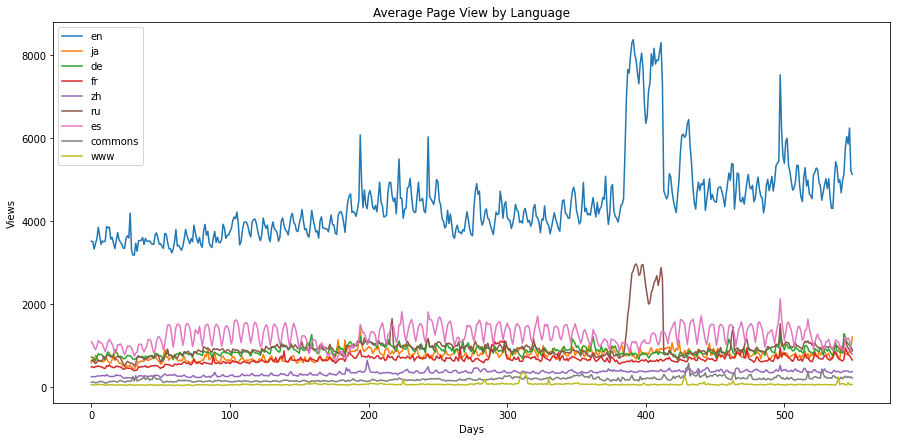

In [21]:
summap = {}
lang_list = ["en", "ja", "de", "fr", "zh", "ru", "es", "commons", "www"]
for l in lang_list:
  summap[l] = df[df.Language == l].iloc[:,:-4].sum(axis = 0)/df[df.Language == l].shape[0]

fig = plt.figure(figsize = (15, 7))
plt.xlabel('Days')
plt.ylabel('Views')
plt.title('Average Page View by Language')

for key in summap:
  plt.plot(days, summap[key], label = key)
plt.legend()
plt.show()




* The overall sum is largelly affected by the English trend. 
* It is difficult to see the trends of minor languages so I will use Forier Transform.

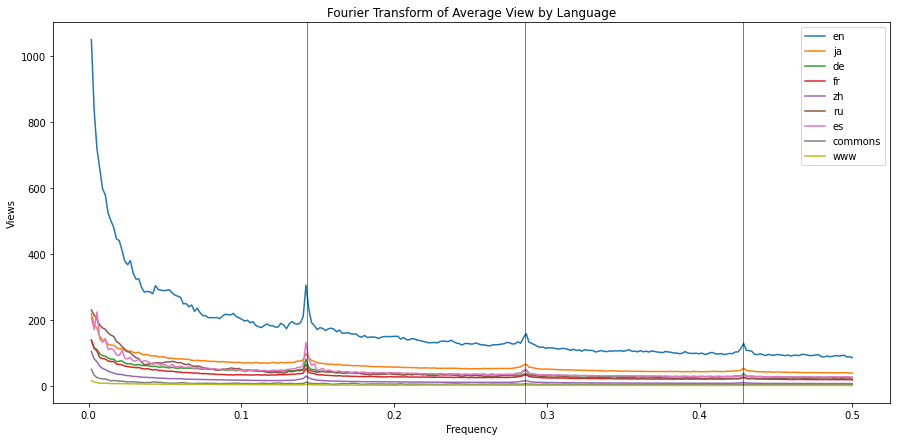

In [22]:
from scipy.fftpack import fft

#data = df.iloc[idx,0:-4]

fig, ax = plt.subplots(figsize = (15, 7))

fftmean = {}
fftxvals = {}

for key in summap:
  fftval = fft(df[df.Language == key].iloc[:, :-6])

#calculate magnitude
  fftmag = [np.sqrt(np.real(x)*np.real(x)+
                    np.imag(x)*np.imag(x)) for x in fftval]
  arr = np.array(fftmag)
#calculate mean
  fftmean[key] = np.mean(arr,axis=0)

  fftxvals[key] = [day/fftmean[key].shape[0] for day in range(fftmean[key].shape[0])]

  npts = len(fftxvals[key])//2 + 1
  fftmean[key] = fftmean[key][:npts]/fftmean[key].shape[0]
  fftxvals[key] = fftxvals[key][:npts]
  ax.plot(fftxvals[key][1:], fftmean[key][1:], label = key)

plt.axvline(x = 1/7, color = 'black', lw = 0.5)
plt.axvline(x = 2/7, color = 'black', lw = 0.5)
plt.axvline(x = 3/7, color = 'black', lw = 0.5)

plt.xlabel('Frequency')
plt.ylabel('Views')
plt.title('Fourier Transform of Average View by Language')

plt.legend()
plt.show()

* There are clear peaks at 1/7, 2/7 and 3/7. They are likely to be the weekly trends as we have 7 days per week. 
* Trends in longer terms (smaller frequency) depend on the language. 

Okay, so now I will take a look at individual page.
Let's check the most viewed pages for each language.

In [0]:
sums = pd.concat([df.iloc[:,-4:], df.iloc[:,:-4].sum(axis = 1)], axis = 1)
sums.columns = ['Title', 'Language', 'Access_type', 'Access_origin', 'sumvalues']

In [0]:
max_list = {}
for l in lang_list:
  lang_sums = sums[sums.Language == l]
  max_list[l] = lang_sums.sumvalues.idxmax()

In [25]:
df[df.index.isin(max_list.values())].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
20970,MediaWiki,www,all-access,all-agents
27330,Wikipédia:Accueil principal,fr,all-access,all-agents
28727,Wikipedia:首页,zh,all-access,all-agents
38573,Main Page,en,all-access,all-agents
45071,Special:Search,commons,all-access,all-agents
92205,Wikipedia:Portada,es,all-access,all-agents
99322,Заглавная страница,ru,all-access,all-agents
120336,メインページ,ja,all-access,all-agents
139119,Wikipedia:Hauptseite,de,all-access,all-agents


- The most viewed pages are the main portal pages of Wikipedia. 


In [0]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'AppleGothic'

def plot_trend(lang, idx):
    fig = plt.figure(1,figsize=(10,5))
    plt.plot(days, df.iloc[idx,:-4])
    plt.xlabel('day')
    plt.ylabel('views')
    plt.title('Most Viewed Pages ({})'.format(lang))  
    plt.show()

findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['AppleGothic'] not found. Falling back to DejaVu Sans.


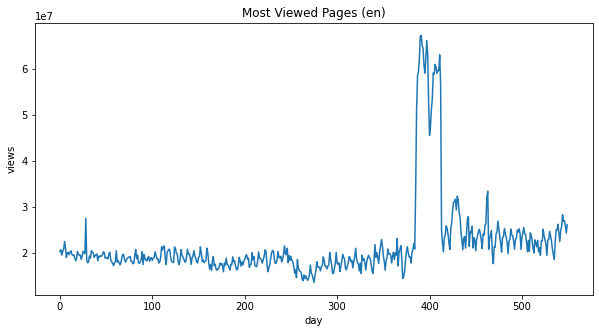

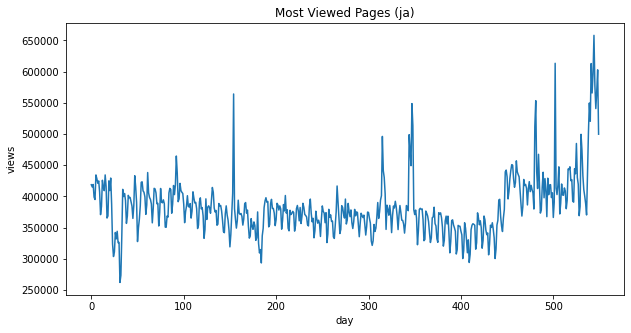

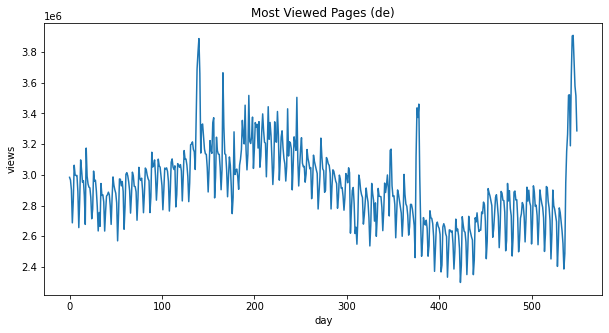

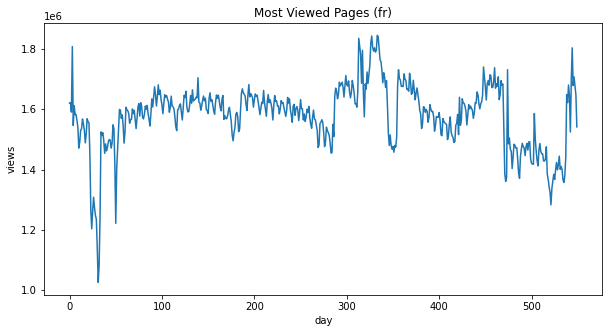

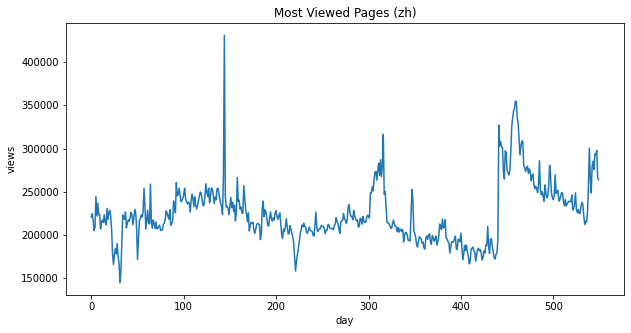

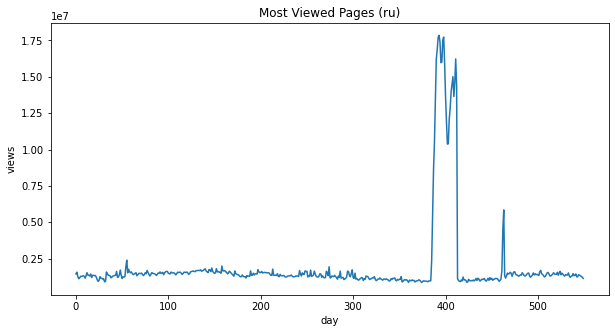

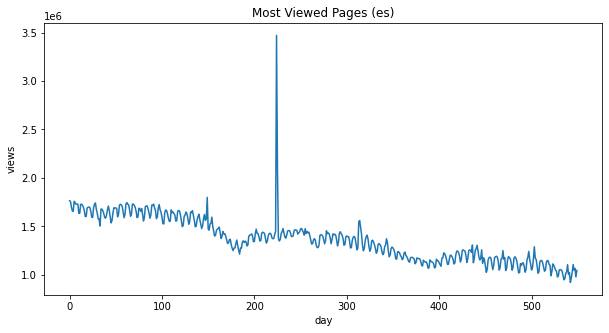

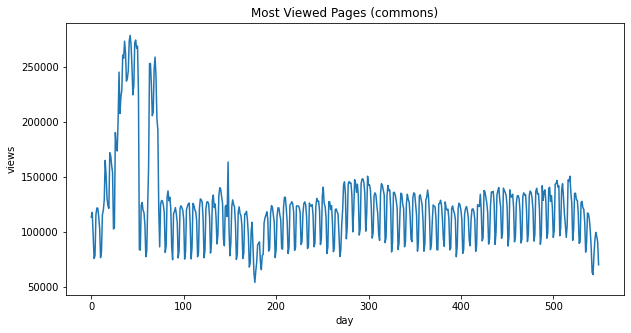

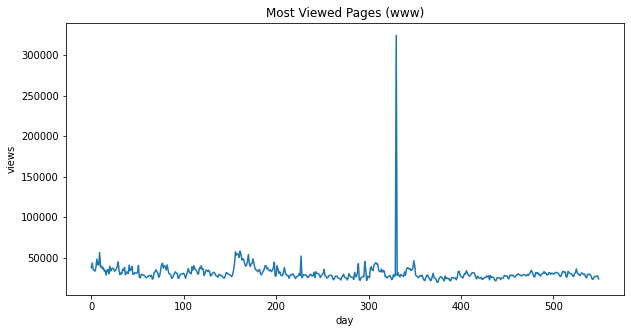

In [27]:
for key in max_list:
  plot_trend(key, max_list[key])

- Each page has unique trend features. 
- There are some weird spikes as well.
- OK, so what about the second largest?

In [28]:
sums2 = sums.drop(labels = max_list.values(), axis = 0)
max_list2 = {}
for l in lang_list:
  lang_sums = sums2[sums2.Language == l]
  max_list2[l] = lang_sums.sumvalues.idxmax()
  
df[df.index.isin(max_list2.values())].iloc[:,-4:]

,Title,Language,Access_type,Access_origin
9774,Main Page,en,desktop,all-agents
43468,MediaWiki,www,desktop,all-agents
55104,Wikipédia:Accueil principal,fr,mobile-web,all-agents
61350,Wikipedia:首页,zh,desktop,all-agents
81665,Special:Search,commons,desktop,all-agents
86431,メインページ,ja,desktop,all-agents
95855,Wikipedia:Portada,es,mobile-web,all-agents
103123,Заглавная страница,ru,desktop,all-agents
116196,Wikipedia:Hauptseite,de,mobile-web,all-agents


- The second most viewed ones are from main pages in different access types. 
- Let's compare the trend by their access type then.


- Why don't we compare the access type to see if there is any difference?

In [0]:
main_titles = dict(zip(list(df[df.index.isin(max_list.values())].Language), list(df[df.index.isin(max_list.values())].Title)))

all_access = {}
mobile_access = {}
desktop_access = {}

for l in lang_list:
  all_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'all-access')]
  mobile_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'mobile-web')]
  desktop_access[l] = df.index[(df.Language == l) & (df.Title == main_titles[l]) & (df.Access_type == 'desktop')]

In [0]:
def plot_trend_access_type(lang):

    plt.figure(figsize=(15,4))

    plt.subplot(1,3, 1)
    plt.plot(days, df.iloc[all_access[l][0],:-4])
    plt.title('All Access ({})'.format(lang))
    plt.subplot(1,3, 2)
    plt.plot(days, df.iloc[mobile_access[l][0],:-4])
    plt.title('Mobile-web Access ({})'.format(lang))
    plt.subplot(1,3, 3)
    plt.plot(days, df.iloc[desktop_access[l][0],:-4])
    plt.title('Desktop Access ({})'.format(lang))
    plt.show()

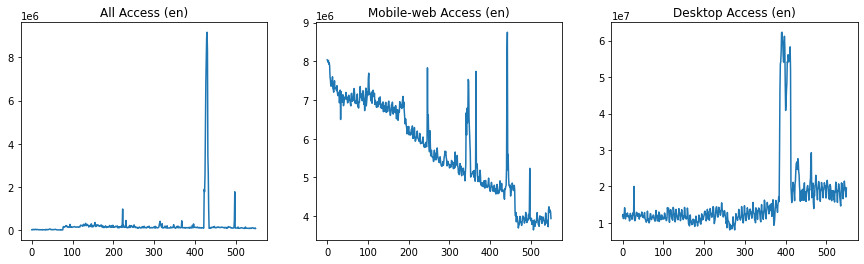

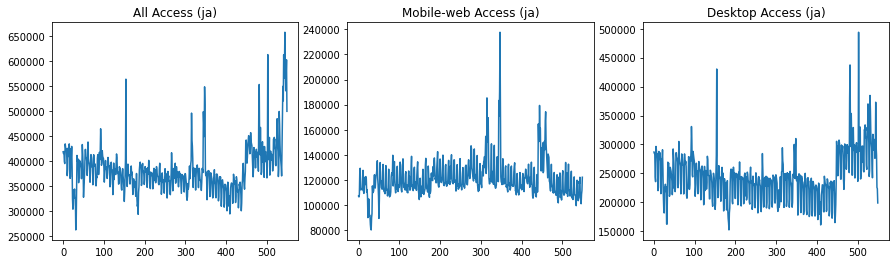

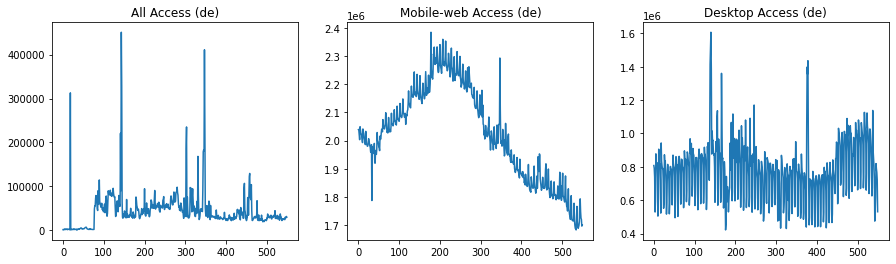

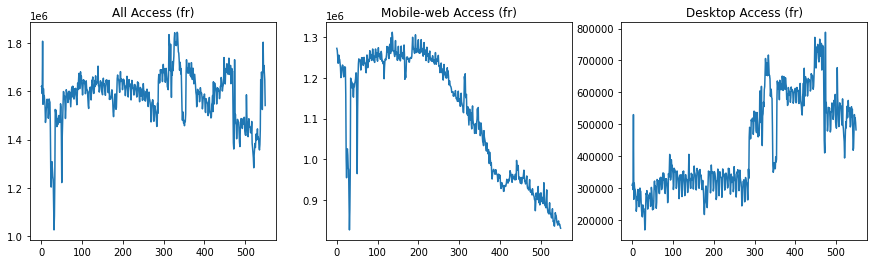

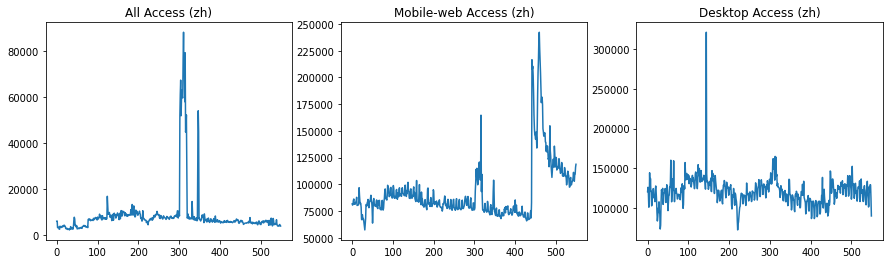

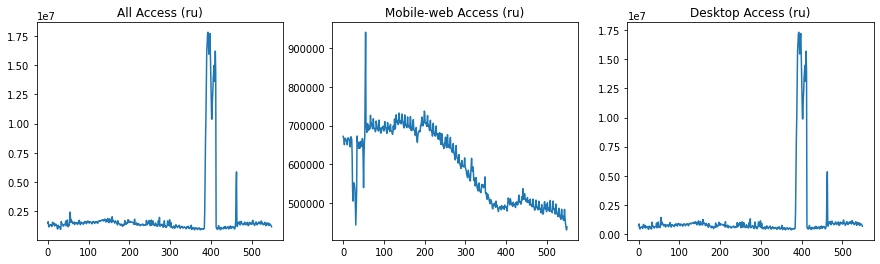

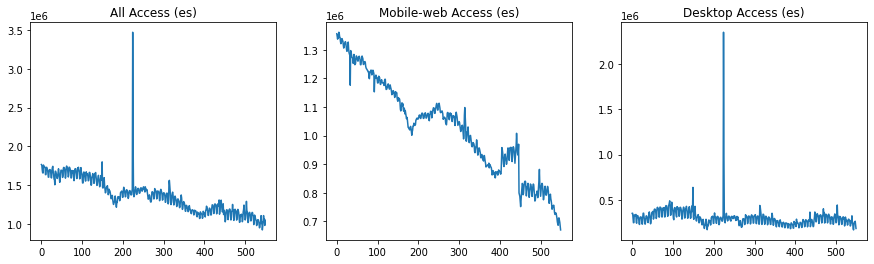

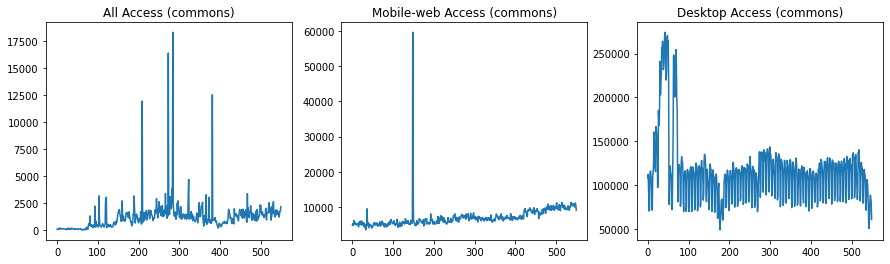

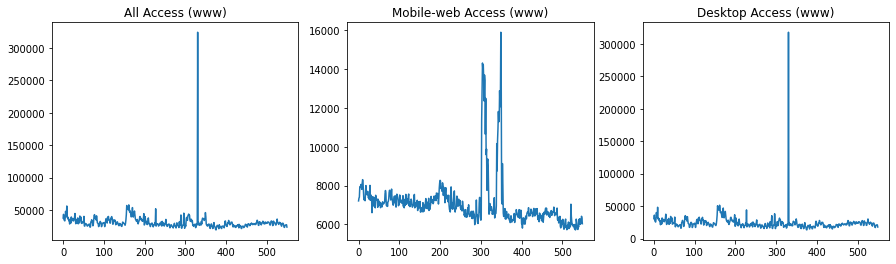

In [31]:
for l in lang_list:
  plot_trend_access_type(l)


- The shapes of the graphs differ a lot depending on the access type. 
- In most of the languages, there are peaks around 300th days, which could be because of the 2016 summer Olympics from Rio. 
- For the case of English, Japanese and French, there are overall decrease in Mobile Access but increase in Desktop Access for some reason... 
- Possible reasons could be... mobile users shifted to desktop? Was there new macbook released?  Or mobile wikipedia degraded? 


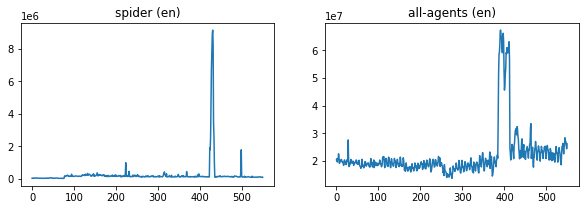

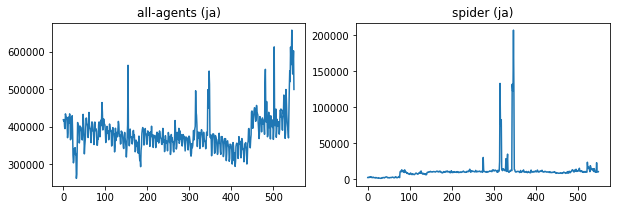

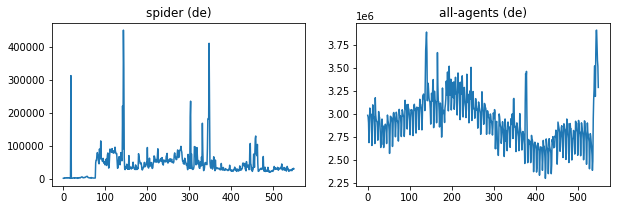

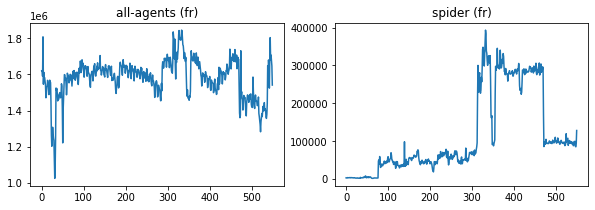

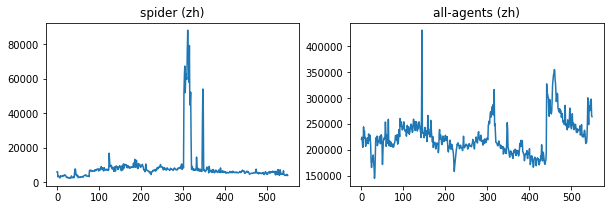

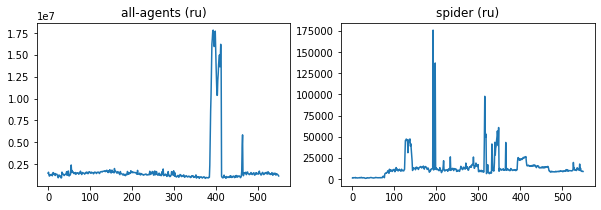

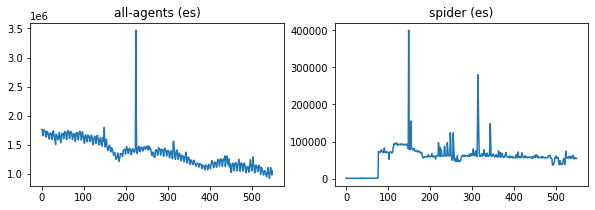

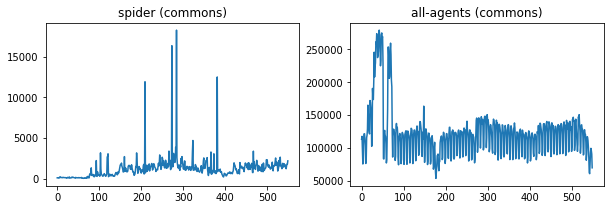

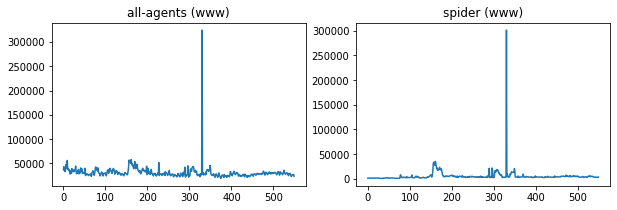

In [32]:
def plot_trend_access_origin(lang):

    plt.figure(figsize=(10,3))

    plt.subplot(1,2, 1)
    plt.plot(days, df.iloc[all_access[l][0],:-4])
    plt.title('{} ({})'.format(df.iloc[all_access[l][0],:].Access_origin,lang))
    plt.subplot(1,2, 2)
    plt.plot(days, df.iloc[all_access[l][1],:-4])
    plt.title('{} ({})'.format(df.iloc[all_access[l][1],:].Access_origin, lang))
    plt.show()
  
for l in lang_list:
    plot_trend_access_origin(l)

- Spider seem to be more constant than all-agent. Perhaps, they are less events driven than normal access.

# Prediction
I will use the first 500 days to predict the last 50 days.

## ARIMA
Let's try ARIMA to predict the views from the time series data.

In [0]:
# Split the data into train and test

series = df.iloc[:, 0:-4]

from sklearn.model_selection import train_test_split

X = series.iloc[:,:500]
y = series.iloc[:,500:]

X_train, X_val, y_train, y_val = train_test_split(X.values, y.values, test_size=0.1, random_state=42)


Let's use walk-forward validation technique to see how the ARIMA model learns and predicts. It will take a lot of time to predict all dataset so I will just use the main page in Japanese.

In [34]:
from statsmodels.tsa.arima_model import ARIMA

train, test = X_train[86431], y_train[86431]
record = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(record, order=(4,1,0))
	model_fit = model.fit(disp=False)
	# forecast one step
	yhat = model_fit.forecast()[0]
	# store the result
	predictions.append(yhat)
	record.append(test[t])


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


RMSE: 5.868


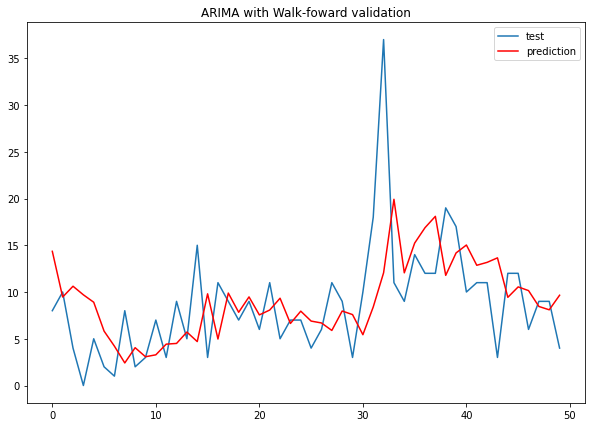

In [35]:
from math import sqrt
from sklearn.metrics import mean_squared_error
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
fig = plt.subplots(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')
plt.legend(['test', 'prediction'])
plt.title('ARIMA with Walk-foward validation')
plt.show()

Let's see how the parameters p, d, q affect our ARIMA model.
- p: Determines the time range to obtain the auto regression (AR)
- q: Determines the time range to obtain moving avereage (MV)
- d: Determines the level of differentiation.

In [0]:

# evaluate an ARIMA model for a given order (p,d,q) with MSE
def evaluate_arima_model(train, test, arima_order):
	# prepare training dataset
	record = [x for x in train]
	# make predictions
	predictions = list()
	for t in range(len(test)):
		model = ARIMA(record, order=arima_order)
		model_fit = model.fit(disp=0)
		yhat = model_fit.forecast()[0]
		predictions.append(yhat)
		record.append(test[t])
	# calculate out of sample error
	error = mean_squared_error(test, predictions)
	aic_score= model_fit.aic
	return error, aic_score


import warnings
warnings.filterwarnings("ignore")


# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(train, test, p_values, d_values, q_values):
	train, test = train.astype('float32'), test.astype('float32')
	best_score, best_cfg = float("inf"), None
	for p in p_values:
		for d in d_values:
			for q in q_values:
				order = (p,d,q)
				try:
					mse, aic = evaluate_arima_model(train, test, order)
					if mse < best_score:
						best_score, best_cfg = mse, order
						aic_out = aic
					print('ARIMA  ', order,    'MSE=%.3f   AIC=%.3f' % ( mse, aic))
				except:
					continue
	#print('Best ARIMA:    ', best_cfg,  'MSE=%.3f  AIC=%.3f' % (best_cfg, best_score))


In [37]:

p_values = [0, 5]
d_values = range(0, 2)
q_values = range(4, 8)
warnings.filterwarnings("ignore")
evaluate_models(X_train[86431], y_train[86431], p_values, d_values, q_values)

ARIMA   (0, 0, 4) MSE=34.201   AIC=5382.980
ARIMA   (0, 0, 5) MSE=34.080   AIC=5382.054
ARIMA   (0, 0, 6) MSE=34.497   AIC=5371.283
ARIMA   (0, 0, 7) MSE=34.298   AIC=5373.053
ARIMA   (5, 0, 4) MSE=45.165   AIC=5359.160
ARIMA   (5, 0, 5) MSE=85.835   AIC=5343.798
ARIMA   (5, 0, 6) MSE=68.060   AIC=5340.202
ARIMA   (5, 0, 7) MSE=55.496   AIC=5318.691
ARIMA   (5, 1, 5) MSE=141.144   AIC=5342.774
ARIMA   (5, 1, 6) MSE=91.897   AIC=5323.920


- So in general,  MSE is smaller at p=0, d=0 and d around 5 to 7.
- In deed, the best combination was when p=0,d = 0 and q = 5.

In [38]:
p_values = [0, 1]
d_values = [0,1]
q_values = [5,7]
warnings.filterwarnings("ignore")
evaluate_models(X_train[86431], y_train[86431], p_values, d_values, q_values)

ARIMA   (0, 0, 7) MSE=34.298   AIC=5373.053
ARIMA   (1, 0, 5) MSE=32.183   AIC=5372.689
ARIMA   (1, 0, 7) MSE=43.823   AIC=5341.804
ARIMA   (1, 1, 5) MSE=83.088   AIC=5364.318


So the best combination was actually 1, 0 ,5.

Let's visualize and compare to the previous result.


RMSE: 5.673


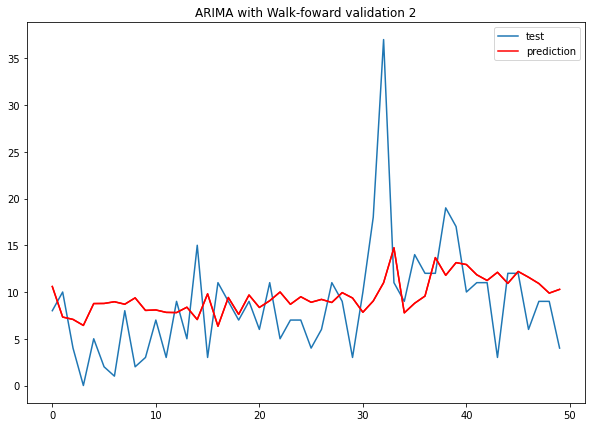

In [39]:


train, test = X_train[86431], y_train[86431]
record = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	# fit model
	model = ARIMA(record, order=(1,0,5))
	model_fit = model.fit(disp=False)
	# forecast one step
	yhat = model_fit.forecast()[0]
	# store the result
	predictions.append(yhat)
	record.append(test[t])
 
# evaluate forecasts
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
fig = plt.subplots(figsize=(10,7))
plt.plot(test)
plt.plot(predictions, color='red')
plt.plot(predictions, color='red')
plt.legend(['test', 'prediction'])
plt.title('ARIMA with Walk-foward validation 2')
plt.show()

- So compared to the previous model, the model is not cpaturing the large spikes, but did not cause any huge error either, which is why this model had the lowest REM.